In [53]:
%load_ext autoreload
%autoreload 2

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pdb
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras import backend as K
from matplotlib import pyplot as plt
%matplotlib inline
import scipy
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom
from scipy.ndimage import imread
import helpers
from models import DaveModel, DaveVGG, DaveVGG19, SimpleModel, LeNetModel
from trainer import Trainer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
train = pd.read_json("_RawData/train.json/data/processed/train.json")
test = pd.read_json("_RawData/test.json/data/processed/test.json")

X = helpers.get_images(train)
X_test = helpers.get_images(test)

y = to_categorical(train.is_iceberg.values,num_classes=2)

Xtr, Xv, ytr, yv = train_test_split(X, y, shuffle=False, test_size=0.20)


In [128]:
from keras.layers import AveragePooling2D
import models
from models import DaveBaseModel
import helpers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Lambda, Activation
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.applications import VGG16, VGG19
import abc
from matplotlib import pyplot as plt
import time
import datetime

class DaveModel2(DaveBaseModel):
    def ConvBlock(model, layers, filters):
        '''Create [layers] layers consisting of zero padding, a convolution with [filters] 3x3 filters and batch normalization. Perform max pooling after the last layer.'''
        for i in range(layers):
            model.add(ZeroPadding2D((1, 1)))
            model.add(Conv2D(filters, (3, 3), activation='relu'))
            model.add(BatchNormalization(axis=3))
            model.add(Dropout(0.5))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    def get_model(self):
        '''Create the FCN and return a keras model.'''

        model = Sequential()

        # Input image: 75x75x3
        model.add(Lambda(lambda x: x, input_shape=(75, 75, 3)))
        DaveModel.ConvBlock(model, 1, 32)
        # 37x37x32
        DaveModel.ConvBlock(model, 1, 64)
        # 18x18x64
        DaveModel.ConvBlock(model, 1, 128)
        # 9x9x128
        DaveModel.ConvBlock(model, 1, 128)
        # 4x4x128
        model.add(ZeroPadding2D((1, 1)))
        model.add(Conv2D(2, (3, 3), activation='relu'))
        model.add(GlobalAveragePooling2D())
        # 4x4x2
        model.add(Activation('softmax'))
        
        model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
        return model
    
    def get_name(self):
        return "davemodel"


In [129]:
model = DaveModel2(Xtr, ytr, Xv, yv)

In [130]:
# model.model.load_weights("01 - 2137.h5")

In [ ]:
model.train(batch_size = 32, epochs = 80)

Model: davemodel
Batch Size: 32
Epochs: 80
Epoch 1/80
41/40 [==============================] - 4s - loss: 0.5384 - acc: 0.7155 - val_loss: 0.6672 - val_acc: 0.65730.
Epoch 2/80
41/40 [==============================] - 1s - loss: 0.4968 - acc: 0.7312 - val_loss: 0.6411 - val_acc: 0.6573
Epoch 3/80
41/40 [==============================] - 2s - loss: 0.4446 - acc: 0.7621 - val_loss: 0.6408 - val_acc: 0.6573
Epoch 4/80
41/40 [==============================] - 1s - loss: 0.4060 - acc: 0.7994 - val_loss: 0.6692 - val_acc: 0.6573
Epoch 5/80
41/40 [==============================] - 1s - loss: 0.4183 - acc: 0.8018 - val_loss: 0.6849 - val_acc: 0.6573
Epoch 6/80
41/40 [==============================] - 2s - loss: 0.4030 - acc: 0.8133 - val_loss: 0.8875 - val_acc: 0.6573
Epoch 7/80
41/40 [==============================] - 2s - loss: 0.3612 - acc: 0.8338 - val_loss: 0.8896 - val_acc: 0.6573
Epoch 8/80
41/40 [==============================] - 2s - loss: 0.3498 - acc: 0.8243 - val_loss: 0.9841 - val

In [ ]:
model.plot_results()

In [103]:
pred_test = model.predict(X_test, test)

In [111]:
# clipping
for p in pred_test:
    print(p[1])
    val = p[1]
    
    if val < 0.025:
        val = 0.025
        
    elif val > 0.975:
        val = 0.975
        
    p[1] = val
    
    print(p[1])

model.create_submission(pred_test, test)

0.0369616
0.0369616
0.196795
0.196795
0.025
0.025
0.975
0.975
0.025
0.025
0.0312446
0.0312446
0.0574131
0.0574131
0.975
0.975
0.025
0.025
0.025
0.025
0.025
0.025
0.0410375
0.0410375
0.025
0.025
0.294159
0.294159
0.025
0.025
0.025
0.025
0.025
0.025
0.0808564
0.0808564
0.0948212
0.0948212
0.975
0.975
0.025
0.025
0.751833
0.751833
0.252036
0.252036
0.0272324
0.0272324
0.025
0.025
0.025
0.025
0.566309
0.566309
0.0661362
0.0661362
0.0257904
0.0257904
0.975
0.975
0.025
0.025
0.6548
0.6548
0.025
0.025
0.025
0.025
0.936005
0.936005
0.923681
0.923681
0.0290829
0.0290829
0.025
0.025
0.025
0.025
0.886727
0.886727
0.029926
0.029926
0.0496582
0.0496582
0.025
0.025
0.025
0.025
0.177203
0.177203
0.661889
0.661889
0.975
0.975
0.348275
0.348275
0.975
0.975
0.025
0.025
0.025
0.025
0.166034
0.166034
0.975
0.975
0.0773542
0.0773542
0.123763
0.123763
0.975
0.975
0.025
0.025
0.128248
0.128248
0.025
0.025
0.025
0.025
0.025
0.025
0.0312221
0.0312221
0.975
0.975
0.296991
0.296991
0.0520963
0.0520963
0.0545643


0.118946
0.118946
0.941532
0.941532
0.13793
0.13793
0.13074
0.13074
0.919576
0.919576
0.509091
0.509091
0.975
0.975
0.025
0.025
0.0492613
0.0492613
0.025
0.025
0.313927
0.313927
0.970596
0.970596
0.224206
0.224206
0.025
0.025
0.025
0.025
0.911998
0.911998
0.0433278
0.0433278
0.801345
0.801345
0.067093
0.067093
0.485473
0.485473
0.0878854
0.0878854
0.92975
0.92975
0.623491
0.623491
0.025
0.025
0.025
0.025
0.025
0.025
0.19078
0.19078
0.025
0.025
0.040799
0.040799
0.025
0.025
0.60829
0.60829
0.975
0.975
0.025
0.025
0.025
0.025
0.0376866
0.0376866
0.975
0.975
0.133031
0.133031
0.742541
0.742541
0.025
0.025
0.0573791
0.0573791
0.573465
0.573465
0.352197
0.352197
0.025
0.025
0.0530096
0.0530096
0.025
0.025
0.96856
0.96856
0.187725
0.187725
0.131131
0.131131
0.591825
0.591825
0.281134
0.281134
0.103923
0.103923
0.0327066
0.0327066
0.025
0.025
0.113619
0.113619
0.961255
0.961255
0.937439
0.937439
0.358256
0.358256
0.025
0.025
0.025
0.025
0.025
0.025
0.975
0.975
0.559745
0.559745
0.324155
0.324

0.025
0.025
0.025
0.025
0.975
0.975
0.025
0.025
0.025
0.025
0.41374
0.41374
0.025
0.025
0.025
0.025
0.025
0.025
0.237458
0.237458
0.025
0.025
0.0798107
0.0798107
0.739859
0.739859
0.0745764
0.0745764
0.025
0.025
0.975
0.975
0.634939
0.634939
0.0561586
0.0561586
0.0355563
0.0355563
0.0693463
0.0693463
0.441577
0.441577
0.025
0.025
0.025
0.025
0.025
0.025
0.025
0.025
0.792871
0.792871
0.025
0.025
0.719304
0.719304
0.025
0.025
0.025
0.025
0.890482
0.890482
0.025
0.025
0.975
0.975
0.975
0.975
0.107179
0.107179
0.437344
0.437344
0.025
0.025
0.621837
0.621837
0.122809
0.122809
0.025
0.025
0.030401
0.030401
0.512112
0.512112
0.025
0.025
0.025
0.025
0.201564
0.201564
0.025
0.025
0.074464
0.074464
0.025
0.025
0.975
0.975
0.0962858
0.0962858
0.70757
0.70757
0.025
0.025
0.513321
0.513321
0.966946
0.966946
0.025
0.025
0.025
0.025
0.106468
0.106468
0.972049
0.972049
0.29002
0.29002
0.025
0.025
0.975
0.975
0.025
0.025
0.025
0.025
0.975
0.975
0.0518122
0.0518122
0.975
0.975
0.025
0.025
0.025
0.025
0.

0.025
0.025
0.025
0.025
0.0684632
0.0684632
0.955185
0.955185
0.975
0.975
0.025
0.025
0.0278371
0.0278371
0.0295323
0.0295323
0.025
0.025
0.0363873
0.0363873
0.542126
0.542126
0.975
0.975
0.187507
0.187507
0.025
0.025
0.704664
0.704664
0.025
0.025
0.025
0.025
0.142045
0.142045
0.975
0.975
0.0300607
0.0300607
0.171726
0.171726
0.025
0.025
0.025
0.025
0.025
0.025
0.320183
0.320183
0.863142
0.863142
0.380441
0.380441
0.025
0.025
0.0333543
0.0333543
0.025
0.025
0.946894
0.946894
0.839975
0.839975
0.025
0.025
0.357297
0.357297
0.025
0.025
0.224844
0.224844
0.975
0.975
0.025
0.025
0.11139
0.11139
0.193684
0.193684
0.0381595
0.0381595
0.279878
0.279878
0.062404
0.062404
0.751801
0.751801
0.025
0.025
0.025
0.025
0.025
0.025
0.025
0.025
0.025
0.025
0.025
0.025
0.973738
0.973738
0.084786
0.084786
0.025
0.025
0.025
0.025
0.603614
0.603614
0.950586
0.950586
0.025
0.025
0.358568
0.358568
0.025
0.025
0.964985
0.964985
0.702894
0.702894
0.025
0.025
0.025
0.025
0.025
0.025
0.190244
0.190244
0.697024
0

0.975
0.975
0.975
0.975
0.0770904
0.0770904
0.025
0.025
0.025
0.025
0.025
0.025
0.503511
0.503511
0.937978
0.937978
0.337163
0.337163
0.0597975
0.0597975
0.685398
0.685398
0.975
0.975
0.025
0.025
0.975
0.975
0.025
0.025
0.218216
0.218216
0.444544
0.444544
0.0323253
0.0323253
0.975
0.975
0.222656
0.222656
0.0361735
0.0361735
0.871895
0.871895
0.974748
0.974748
0.150898
0.150898
0.397852
0.397852
0.975
0.975
0.124952
0.124952
0.198408
0.198408
0.025
0.025
0.0814909
0.0814909
0.955749
0.955749
0.478331
0.478331
0.975
0.975
0.036044
0.036044
0.025
0.025
0.025
0.025
0.025
0.025
0.025
0.025
0.46121
0.46121
0.12385
0.12385
0.025
0.025
0.16372
0.16372
0.025
0.025
0.0449038
0.0449038
0.975
0.975
0.860858
0.860858
0.101663
0.101663
0.0664645
0.0664645
0.0355116
0.0355116
0.025
0.025
0.035743
0.035743
0.949917
0.949917
0.0510591
0.0510591
0.025
0.025
0.025
0.025
0.124609
0.124609
0.025
0.025
0.538973
0.538973
0.0363512
0.0363512
0.025
0.025
0.206855
0.206855
0.278488
0.278488
0.025
0.025
0.051896

0.251413
0.251413
0.0465
0.0465
0.975
0.975
0.025
0.025
0.025
0.025
0.0704653
0.0704653
0.025
0.025
0.0402858
0.0402858
0.460714
0.460714
0.025
0.025
0.025
0.025
0.941521
0.941521
0.975
0.975
0.705799
0.705799
0.0459692
0.0459692
0.0711934
0.0711934
0.025
0.025
0.025
0.025
0.0638216
0.0638216
0.709575
0.709575
0.331887
0.331887
0.182585
0.182585
0.025
0.025
0.975
0.975
0.473479
0.473479
0.108057
0.108057
0.025
0.025
0.930739
0.930739
0.799212
0.799212
0.025
0.025
0.0580049
0.0580049
0.025
0.025
0.88885
0.88885
0.160502
0.160502
0.121026
0.121026
0.272344
0.272344
0.135055
0.135055
0.025
0.025
0.975
0.975
0.0253756
0.0253756
0.735249
0.735249
0.0338473
0.0338473
0.975
0.975
0.025
0.025
0.025
0.025
0.131105
0.131105
0.72407
0.72407
0.255606
0.255606
0.203194
0.203194
0.232727
0.232727
0.675016
0.675016
0.025
0.025
0.025
0.025
0.025
0.025
0.227308
0.227308
0.784696
0.784696
0.025
0.025
0.025
0.025
0.025
0.025
0.276938
0.276938
0.025
0.025
0.962302
0.962302
0.905546
0.905546
0.025
0.025
0.

0.116055
0.116055
0.0372278
0.0372278
0.975
0.975
0.842792
0.842792
0.841917
0.841917
0.436151
0.436151
0.224939
0.224939
0.0670489
0.0670489
0.414836
0.414836
0.0710129
0.0710129
0.693863
0.693863
0.107211
0.107211
0.025
0.025
0.025
0.025
0.076051
0.076051
0.025
0.025
0.0741337
0.0741337
0.0951103
0.0951103
0.0627026
0.0627026
0.0594068
0.0594068
0.025
0.025
0.0759522
0.0759522
0.19677
0.19677
0.025
0.025
0.0571028
0.0571028
0.025
0.025
0.975
0.975
0.025
0.025
0.025
0.025
0.0713704
0.0713704
0.025
0.025
0.025
0.025
0.598842
0.598842
0.952286
0.952286
0.025
0.025
0.025
0.025
0.654825
0.654825
0.0328933
0.0328933
0.174101
0.174101
0.0257486
0.0257486
0.025
0.025
0.207208
0.207208
0.025
0.025
0.154007
0.154007
0.113828
0.113828
0.149014
0.149014
0.903128
0.903128
0.361058
0.361058
0.0800546
0.0800546
0.850076
0.850076
0.025
0.025
0.337046
0.337046
0.170801
0.170801
0.971791
0.971791
0.025
0.025
0.025
0.025
0.969508
0.969508
0.025
0.025
0.975
0.975
0.025
0.025
0.353653
0.353653
0.0405125


0.0513644
0.300184
0.300184
0.025
0.025
0.206176
0.206176
0.134271
0.134271
0.127896
0.127896
0.975
0.975
0.453902
0.453902
0.665471
0.665471
0.106418
0.106418
0.861346
0.861346
0.0265883
0.0265883
0.521707
0.521707
0.025
0.025
0.18946
0.18946
0.0410161
0.0410161
0.0368347
0.0368347
0.108509
0.108509
0.100823
0.100823
0.9393
0.9393
0.895268
0.895268
0.356274
0.356274
0.356992
0.356992
0.025
0.025
0.025
0.025
0.975
0.975
0.595665
0.595665
0.47533
0.47533
0.025
0.025
0.975
0.975
0.96823
0.96823
0.0389544
0.0389544
0.9003
0.9003
0.398366
0.398366
0.132556
0.132556
0.145826
0.145826
0.212657
0.212657
0.119876
0.119876
0.025
0.025
0.317515
0.317515
0.733209
0.733209
0.025
0.025
0.025
0.025
0.864617
0.864617
0.025
0.025
0.025
0.025
0.0553301
0.0553301
0.207811
0.207811
0.025
0.025
0.0733645
0.0733645
0.025
0.025
0.452914
0.452914
0.975
0.975
0.975
0.975
0.025
0.025
0.840006
0.840006
0.200725
0.200725
0.025
0.025
0.025
0.025
0.538932
0.538932
0.844441
0.844441
0.025
0.025
0.025
0.025
0.278836

0.0587279
0.025
0.025
0.975
0.975
0.025
0.025
0.0456951
0.0456951
0.69682
0.69682
0.0802122
0.0802122
0.0264434
0.0264434
0.434921
0.434921
0.025
0.025
0.0282373
0.0282373
0.975
0.975
0.025
0.025
0.216246
0.216246
0.0506829
0.0506829
0.975
0.975
0.025
0.025


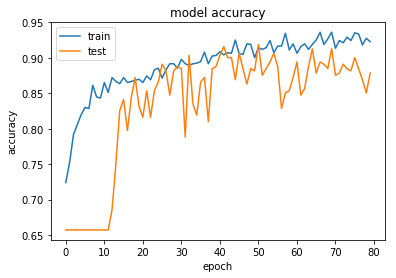

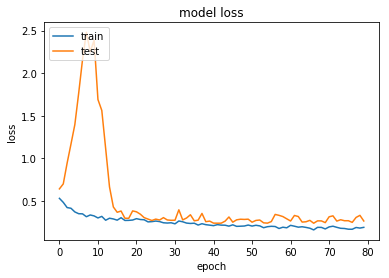

In [37]:
model.plot_results()

Model: davemodel
Batch Size: 32
Epochs: 80
Epoch 1/80
41/40 [==============================] - 2s - loss: 0.5765 - acc: 0.6737 - val_loss: 0.6837 - val_acc: 0.5670
Epoch 2/80
41/40 [==============================] - 1s - loss: 0.4909 - acc: 0.7430 - val_loss: 0.6349 - val_acc: 0.6573
Epoch 3/80
41/40 [==============================] - 1s - loss: 0.4433 - acc: 0.7682 - val_loss: 0.6643 - val_acc: 0.6573
Epoch 4/80
41/40 [==============================] - 1s - loss: 0.4224 - acc: 0.7971 - val_loss: 0.6887 - val_acc: 0.6573
Epoch 5/80
41/40 [==============================] - 1s - loss: 0.3804 - acc: 0.8159 - val_loss: 0.6811 - val_acc: 0.6573
Epoch 6/80
41/40 [==============================] - 1s - loss: 0.3792 - acc: 0.8174 - val_loss: 0.8034 - val_acc: 0.6573
Epoch 7/80
41/40 [==============================] - 1s - loss: 0.3465 - acc: 0.8437 - val_loss: 0.9113 - val_acc: 0.6573
Epoch 8/80
41/40 [==============================] - 1s - loss: 0.3302 - acc: 0.8460 - val_loss: 0.9754 - val_a

41/40 [==============================] - 1s - loss: 0.2076 - acc: 0.9150 - val_loss: 0.3790 - val_acc: 0.8069
Epoch 68/80
41/40 [==============================] - 1s - loss: 0.2085 - acc: 0.9085 - val_loss: 0.2666 - val_acc: 0.8972
Epoch 69/80
41/40 [==============================] - 1s - loss: 0.2015 - acc: 0.9192 - val_loss: 0.2968 - val_acc: 0.8660
Epoch 70/80
41/40 [==============================] - 1s - loss: 0.2027 - acc: 0.9184 - val_loss: 0.3313 - val_acc: 0.8380
Epoch 71/80
41/40 [==============================] - 1s - loss: 0.2092 - acc: 0.9184 - val_loss: 0.2806 - val_acc: 0.8941
Epoch 72/80
41/40 [==============================] - 1s - loss: 0.2120 - acc: 0.9123 - val_loss: 0.2785 - val_acc: 0.8785
Epoch 73/80
41/40 [==============================] - 1s - loss: 0.2019 - acc: 0.9165 - val_loss: 0.3200 - val_acc: 0.8567
Epoch 74/80
41/40 [==============================] - 1s - loss: 0.1963 - acc: 0.9138 - val_loss: 0.2473 - val_acc: 0.9034
Epoch 75/80
41/40 [=================

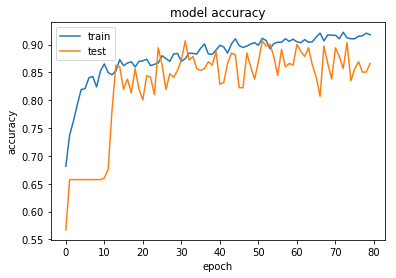

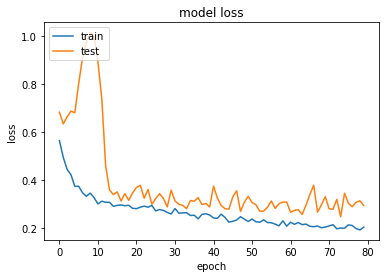

In [38]:
model = DaveModel(Xtr, ytr, Xv, yv)
model.train(32, 80)
model.plot_results()